In [1]:
using MAT
using WebIO
using PyCall
using PyPlot
using Eirene
using Random
using Statistics
using Glob
using DelimitedFiles
using NPZ

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-6806258501131421771\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-3873877625265522934\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-6806258501131421771\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [94]:
#expects path to the position file and types file.
function getdata(positionfilename, typesfilename)
    posarray = readdlm(positionfilename, ',', '\n');
    posx = [];
    posy = []
    for j in 1:size(posarray)[2]
        posarray[j] = chop(posarray[j]);
        xsign = 1;
        x_y = split(posarray[j], '-');
        if(x_y[1] == "")
            xsign = -1;
            x_y = deleteat!(x_y,1);
        end
        x_plus_y = [];
        if(size(x_y)[1] == 1)
            x_plus_y = split(posarray[j], '+');
            x_plus_y = map(a->parse(Float64,a),x_plus_y);
            push!(posx, x_plus_y[1]);
            push!(posy, x_plus_y[2]);
        else
            x_y = map(a->parse(Float64,a),x_y);
            x_y[1] *= xsign;
            x_y[2] *= -1;
            push!(posx,x_y[1]);
            push!(posy,x_y[2]);
        end
    end
    

    typesarray = readdlm(typesfilename, ',','\n');
    typesarray = Array{Int64,2}(typesarray)
    positions = transpose(hcat(posx, posy))
    return (positions,typesarray);
end

getdata (generic function with 2 methods)

In [163]:
function getalldatafortype(typeofsimunderscore, numberofsim)
    totaldata = []
    for i in 1:numberofsim
        foldername = string("DAH_",typeofsimunderscore, "_",i);
        filename = string(foldername , "/Pos_1000000.dat");
        typefilename = string(foldername,  "/Types_1000000.dat");
        (a,b) = getdata(filename,typefilename);
        push!(totaldata, (a,b));
    end
    return totaldata;
end

getalldatafortype (generic function with 2 methods)

In [135]:
function gettypeseparateddata(data,typedata,typesarray)
    results = []
    for i in 1:size(typesarray,1)
        iindices = findall(x->x == typesarray[i], typedata);
        actualindices = getindex.(iindices, [1]);
        datawheni = data[:,actualindices]
        push!(results,datawheni)
    end
    return results
end

gettypeseparateddata (generic function with 1 method)

In [227]:
function separatedataforall(totaldata, typearray)
    separateddata1 = Dict{Int64, Array{Float64,2}}();
    separateddata2 = Dict{Int64, Array{Float64,2}}();
    for i = 1:size(totaldata,1)
        (togetherdata, types) = totaldata[i];
        cell1, cell2 = gettypeseparateddata(togetherdata, types,typearray);
        push!(separateddata1,i => cell1)
        push!(separateddata2, i => cell2)
    end
    return separateddata1,separateddata2
end

separatedataforall (generic function with 1 method)

In [264]:
function wassersteinfromdiagram(complete,lipid,twophase)
    alltogetherinorder = Array{ Dict{String,Any}}(undef, 15, 1);
    wassersteindistances = Array{Float64}(undef,15,15);
    for i in 1:5
        alltogetherinorder[i] = complete[i];
        alltogetherinorder[i+5] = lipid[i];
        alltogetherinorder[i+10] = twophase[i];
    end
    for j in 1:15
        for k in 1:15
            currentbarcode = barcode(alltogetherinorder[j]);
            otherbarcode = barcode(alltogetherinorder[k]);
            wassersteindistances[j,k] = wasserstein_distance(currentbarcode, otherbarcode, q=2, p=2)
        end
    end
    return wassersteindistances;
end

wassersteinfromdiagram (generic function with 1 method)

In [229]:
function plot_dim0_barcode(dim0barcode_data)
    s = sortperm(dim0barcode_data[:,2]-dim0barcode_data[:,1], alg=MergeSort)
    dim0barcode_data = dim0barcode_data[s,:]
    bar_lengths = dim0barcode_data[:,2] - dim0barcode_data[:,1]
    num_bars = size(bar_lengths)[1]
    delta_y = 0.1*num_bars
    figure(figsize=(8,8), dpi=600)
    y_cur = 0.0
    max_length = 0.0
    for len in bar_lengths
        if len != Inf
            if len > max_length
                    max_length = len
            end
            scatter(0.0, y_cur, s=2, color=:darkblue)
            scatter(len, y_cur, s=2, color=:darkblue)
            plot([0.0, len], [y_cur, y_cur], color=:darkblue)
            y_cur += delta_y
        end
    end
    scatter(0.0, y_cur, s=2, color=:darkblue)
    plot([0.0, max_length+0.2], [y_cur, y_cur], color=:darkblue)
    xlim(-0.01, max_length+0.1)
    ylim(-delta_y, y_cur+delta_y)
    yticks([])
    xlabel(L"$\epsilon$")
    ylabel(L"$H_0$")
end

function plot_persistence_diag(dim0barcode_data, dim1barcode_data)
    dim0_bar_lengths = dim0barcode_data[:,2] - dim0barcode_data[:,1]
    max_x = maximum(dim1barcode_data[:,1])
    max_y = 0.0
    figure(figsize=(8,8), dpi=600)
    for i in range(1, length=length(dim0_bar_lengths))
        len = dim0_bar_lengths[i]
        if len != Inf
            if len > max_y
                max_y = len
            end
            scatter(dim0barcode_data[i,1], dim0barcode_data[i,2], color=:darkblue, s=16)
        end
    end
    max_dim1_y = maximum(dim1barcode_data[:,2])
    max_y = maximum([max_y, max_dim1_y])
    scatter(dim1barcode_data[:,1], dim1barcode_data[:,2], color=:darkorange, s=16)
    max_plot_len = maximum([max_x, max_y])
    plot([0, max_plot_len+2], [0, max_plot_len+2], color=:black, "--")
    xlim([-0.1, max_x+0.5])
    ylim([-0.1, max_y+0.5])
    scatter(0.0, max_y+0.5-0.05, color=:darkblue, s=16)
    xlabel(L"$\epsilon$")
    ylabel(L"$\epsilon$")
    show()
end



plot_persistence_diag (generic function with 1 method)

In [169]:
completesortdata = getalldatafortype("Complete_Sorting",5)
lipidbilayerdata = getalldatafortype("Lipid_Bilayer",5)
twophasedata = getalldatafortype("Two_Phase",5)


5-element Array{Any,1}:
 ([-3.7033 -4.4888 … 9.5404 6.9636; 3.3718 -3.4289 … -7.788 1.7323], [1; 2; … ; 1; 1])    
 ([0.068555 -1.8929 … 1.8379 4.6219; -4.4467 -1.9108 … -2.2695 -1.8107], [1; 1; … ; 1; 1])
 ([4.3015 -2.4857 … 3.6896 0.7686; 1.8279 3.137 … 7.8753 6.8873], [2; 2; … ; 1; 1])       
 ([2.6884 3.1099 … 4.0662 6.6172; 1.9495 3.0342 … -3.049 0.47987], [2; 2; … ; 1; 1])      
 ([-5.4463 1.4054 … 3.7296 7.9929; 4.974 3.5546 … 9.1941 -8.4204], [2; 2; … ; 1; 1])      

In [228]:
completesort1,completesort2 = separatedataforall(completesortdata, [1,2])
lipid1,lipid2 = separatedataforall(lipidbilayerdata, [1,2])
twophase1,twophase2 = separatedataforall(twophasedata, [1,2])

(Dict(4 => [-2.4744 2.2698 … 4.0662 6.6172; -2.5747 -1.5467 … -3.049 0.47987],2 => [0.068555 -1.8929 … 1.8379 4.6219; -4.4467 -1.9108 … -2.2695 -1.8107],3 => [-1.54 -7.469 … 3.6896 0.7686; -2.9374 -1.734 … 7.8753 6.8873],5 => [1.03 -3.7718 … 3.7296 7.9929; -7.3612 2.9856 … 9.1941 -8.4204],1 => [-3.7033 4.8422 … 9.5404 6.9636; 3.3718 -3.9042 … -7.788 1.7323]), Dict(4 => [2.6884 3.1099 … 0.13669 1.9684; 1.9495 3.0342 … 0.78059 3.4294],2 => [-1.9021 -5.0457 … -6.3167 4.2399; -0.85709 -0.061932 … 7.1314 4.3712],3 => [4.3015 -2.4857 … -2.4971 5.9508; 1.8279 3.137 … 4.2174 3.3282],5 => [-5.4463 1.4054 … 4.1 4.0345; 4.974 3.5546 … 1.0784 4.1089],1 => [-4.4888 -3.9264 … -4.8488 4.9675; -3.4289 -5.1332 … 2.5276 -5.4437]))

In [243]:
completecell1diagrams = Dict{Int64, Dict{String,Any}}();
lipidcell1diagrams = Dict{Int64, Dict{String,Any}}();
twophasecell1diagrams = Dict{Int64, Dict{String,Any}}();
completecell2diagrams = Dict{Int64, Dict{String,Any}}();
lipidcell2diagrams = Dict{Int64, Dict{String,Any}}();
twophasecell2diagrams = Dict{Int64, Dict{String,Any}}();
for j = 1:5
    compdiagram = eirene(completesort1[j], model = "pc", maxdim = 1, maxrad = 10);  
    lipiddiagram = eirene(lipid1[j], model = "pc", maxdim = 1, maxrad = 10); 
    twophasediagram = eirene(twophase1[j], model = "pc", maxdim = 1, maxrad = 10); 
    push!(completecell1diagrams, j=>compdiagram);
    push!(lipidcell1diagrams, j=>lipiddiagram);
    push!(twophasecell1diagrams, j=>twophasediagram);
end
for j = 1:5
    compdiagram = eirene(completesort2[j], model = "pc", maxdim = 1, maxrad = 10);  
    lipiddiagram = eirene(lipid2[j], model = "pc", maxdim = 1, maxrad = 10); 
    twophasediagram = eirene(twophase2[j], model = "pc", maxdim = 1, maxrad = 10); 
    push!(completecell2diagrams, j=>compdiagram);
    push!(lipidcell2diagrams, j=>lipiddiagram);
    push!(twophasecell2diagrams, j=>twophasediagram);
end

In [245]:
completeallcell = Dict{Int64, Dict{String,Any}}();
lipidallcell = Dict{Int64, Dict{String,Any}}();
twophaseallcell = Dict{Int64, Dict{String,Any}}();
for i = 1:5
    compdiagram = eirene(completesortdata[i][1], model = "pc", maxdim = 1, maxrad = 10);  
    lipiddiagram = eirene(lipidbilayerdata[i][1], model = "pc", maxdim = 1, maxrad = 10); 
    twophasediagram = eirene(twophasedata[i][1], model = "pc", maxdim = 1, maxrad = 10); 
    push!(completeallcell, i=>compdiagram);
    push!(lipidallcell, i=>lipiddiagram);
    push!(twophaseallcell, i=>twophasediagram);
end

In [265]:
#wasserstein matrix for cell type 1
celltype1wasserstein = wassersteinfromdiagram(completecell1diagrams,lipidcell1diagrams,twophasecell1diagrams);
#wasserstein for cell type 2
celltype2wasserstein = wassersteinfromdiagram(completecell2diagrams,lipidcell2diagrams,twophasecell2diagrams);
#wasserstein for all cell
celltogetherwasserstein = wassersteinfromdiagram(completeallcell,lipidallcell,twophaseallcell);

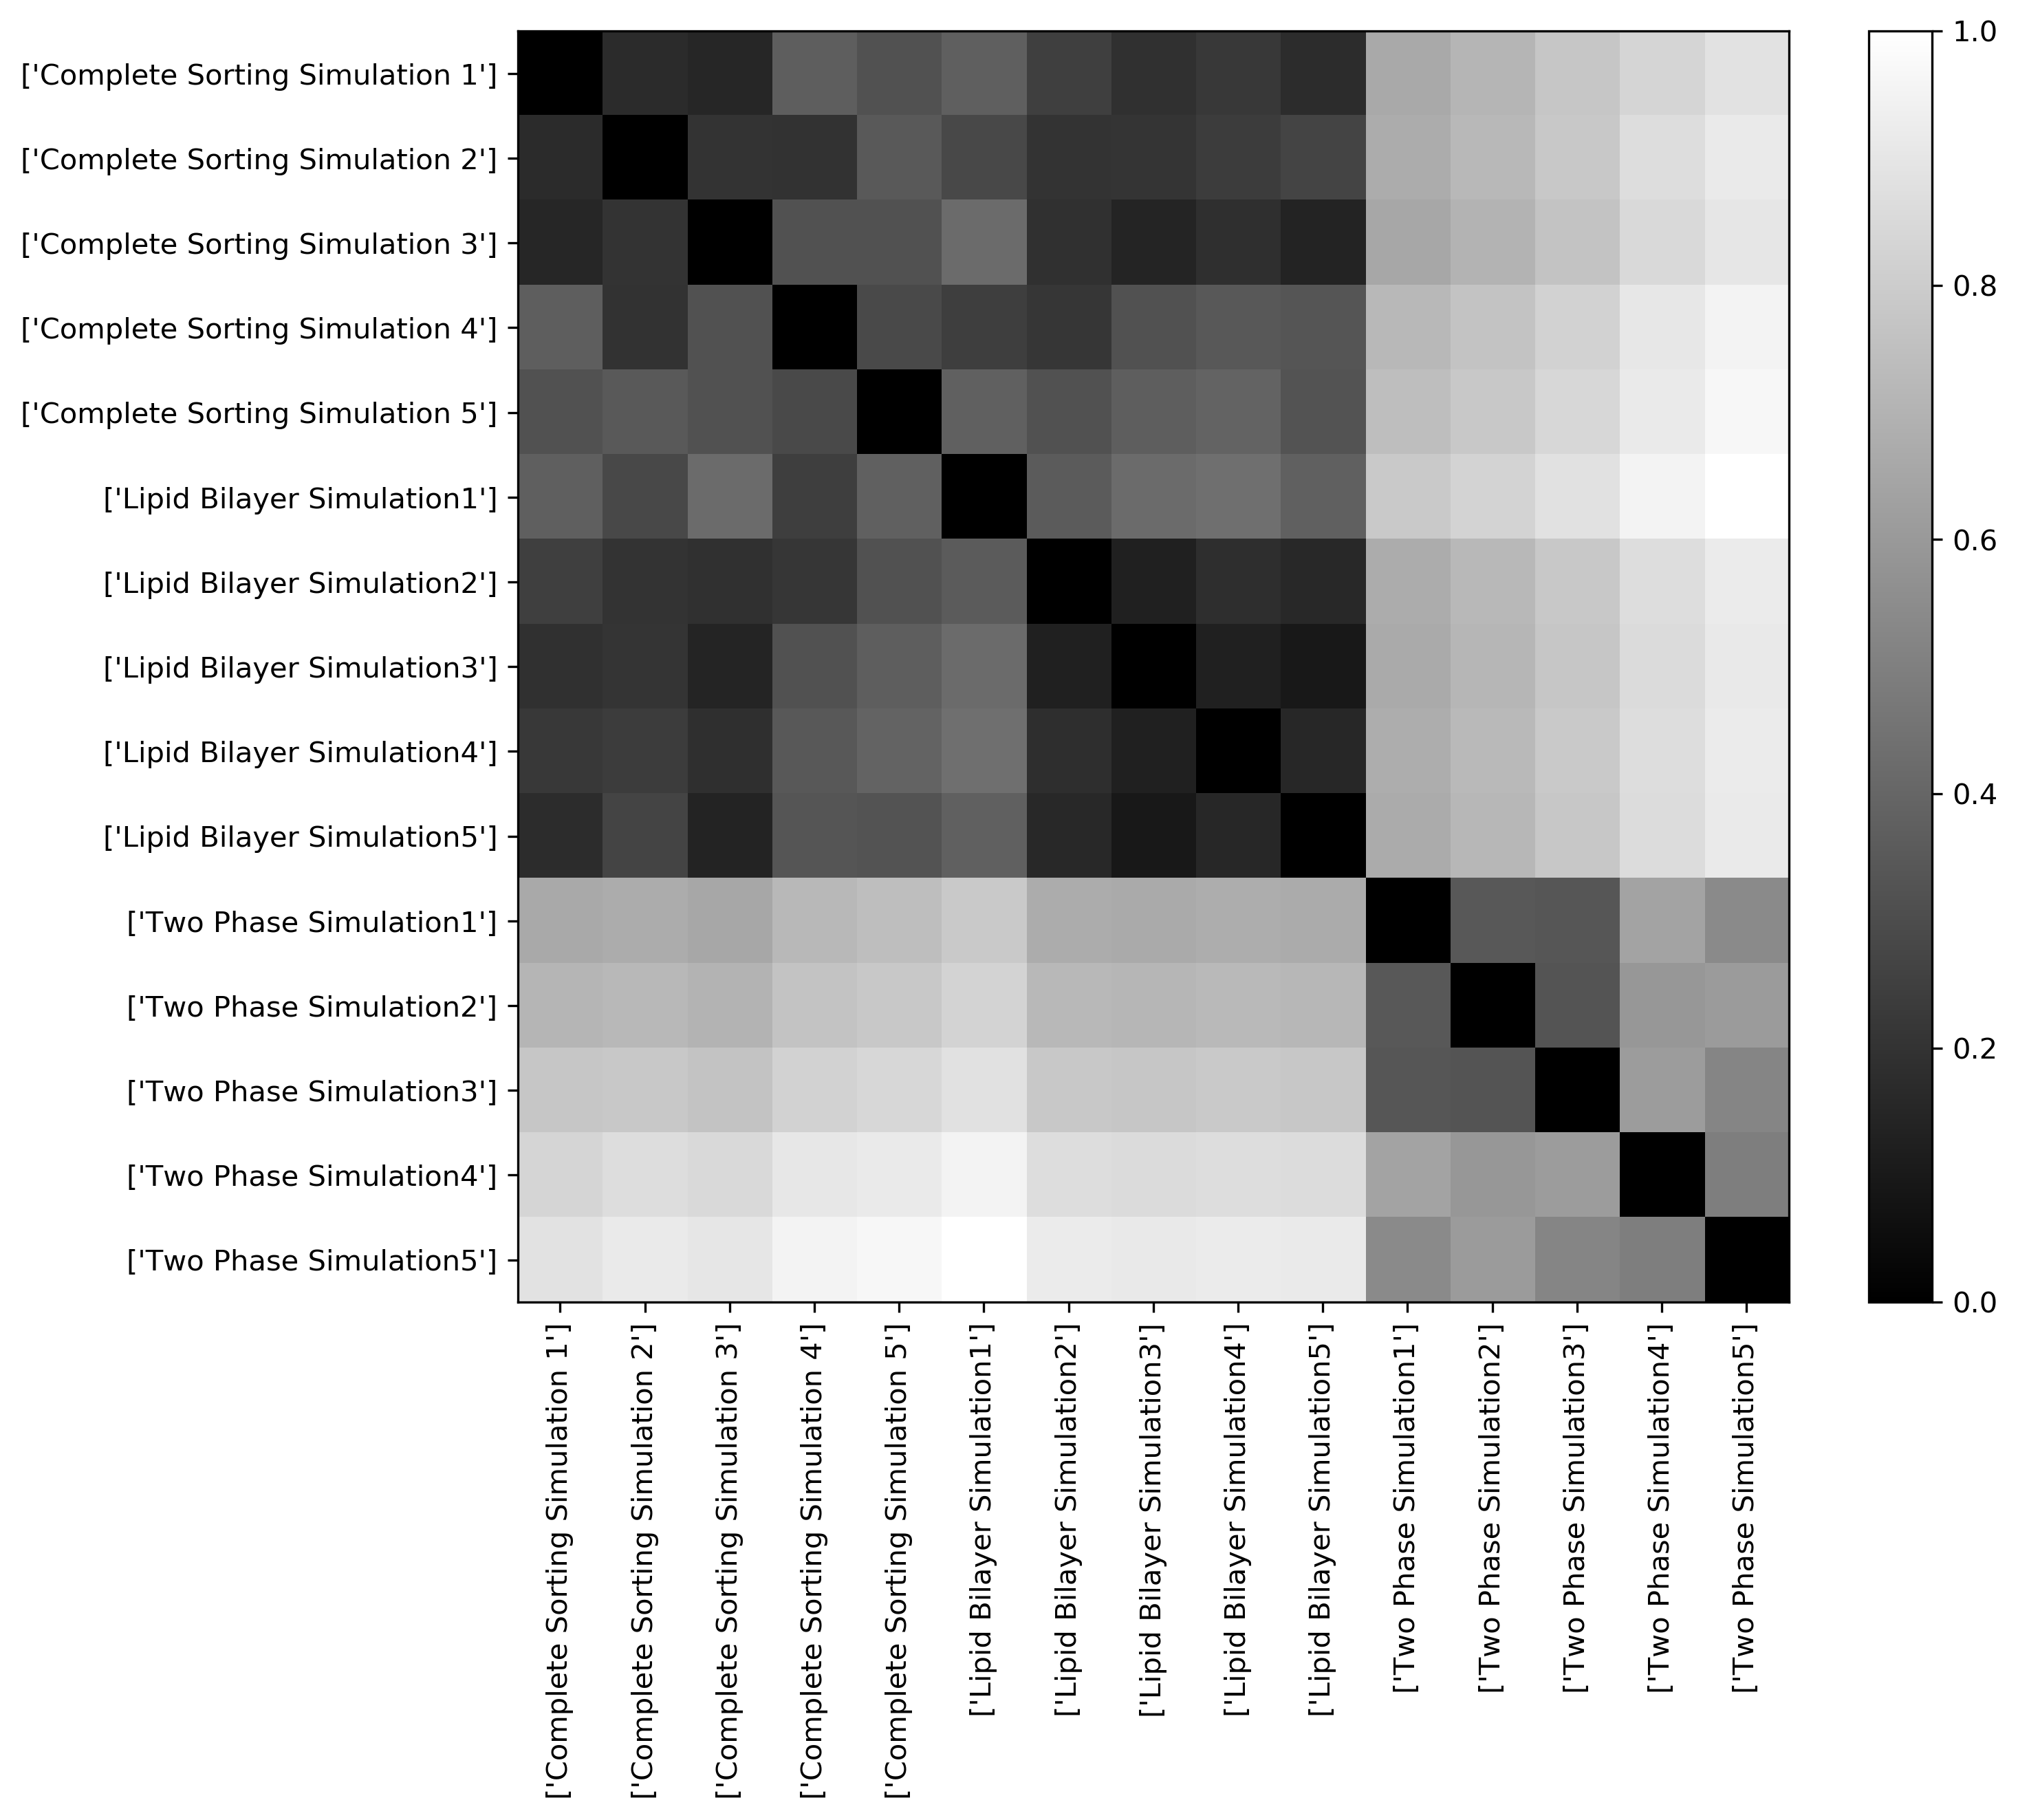

In [269]:
max_coord = maximum(celltype1wasserstein)
wassmatrix = celltype1wasserstein/max_coord

well_names = Array{String}(undef, 15,1);
for i in 1:5
        well_names[i] = string("Complete Sorting Simulation ",i);
        well_names[i+5] = string("Lipid Bilayer Simulation", i);
        well_names[i+10] = string("Two Phase Simulation", i);
end

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:14, well_names, rotation=90);
yticks(0:14, well_names);
colorbar();

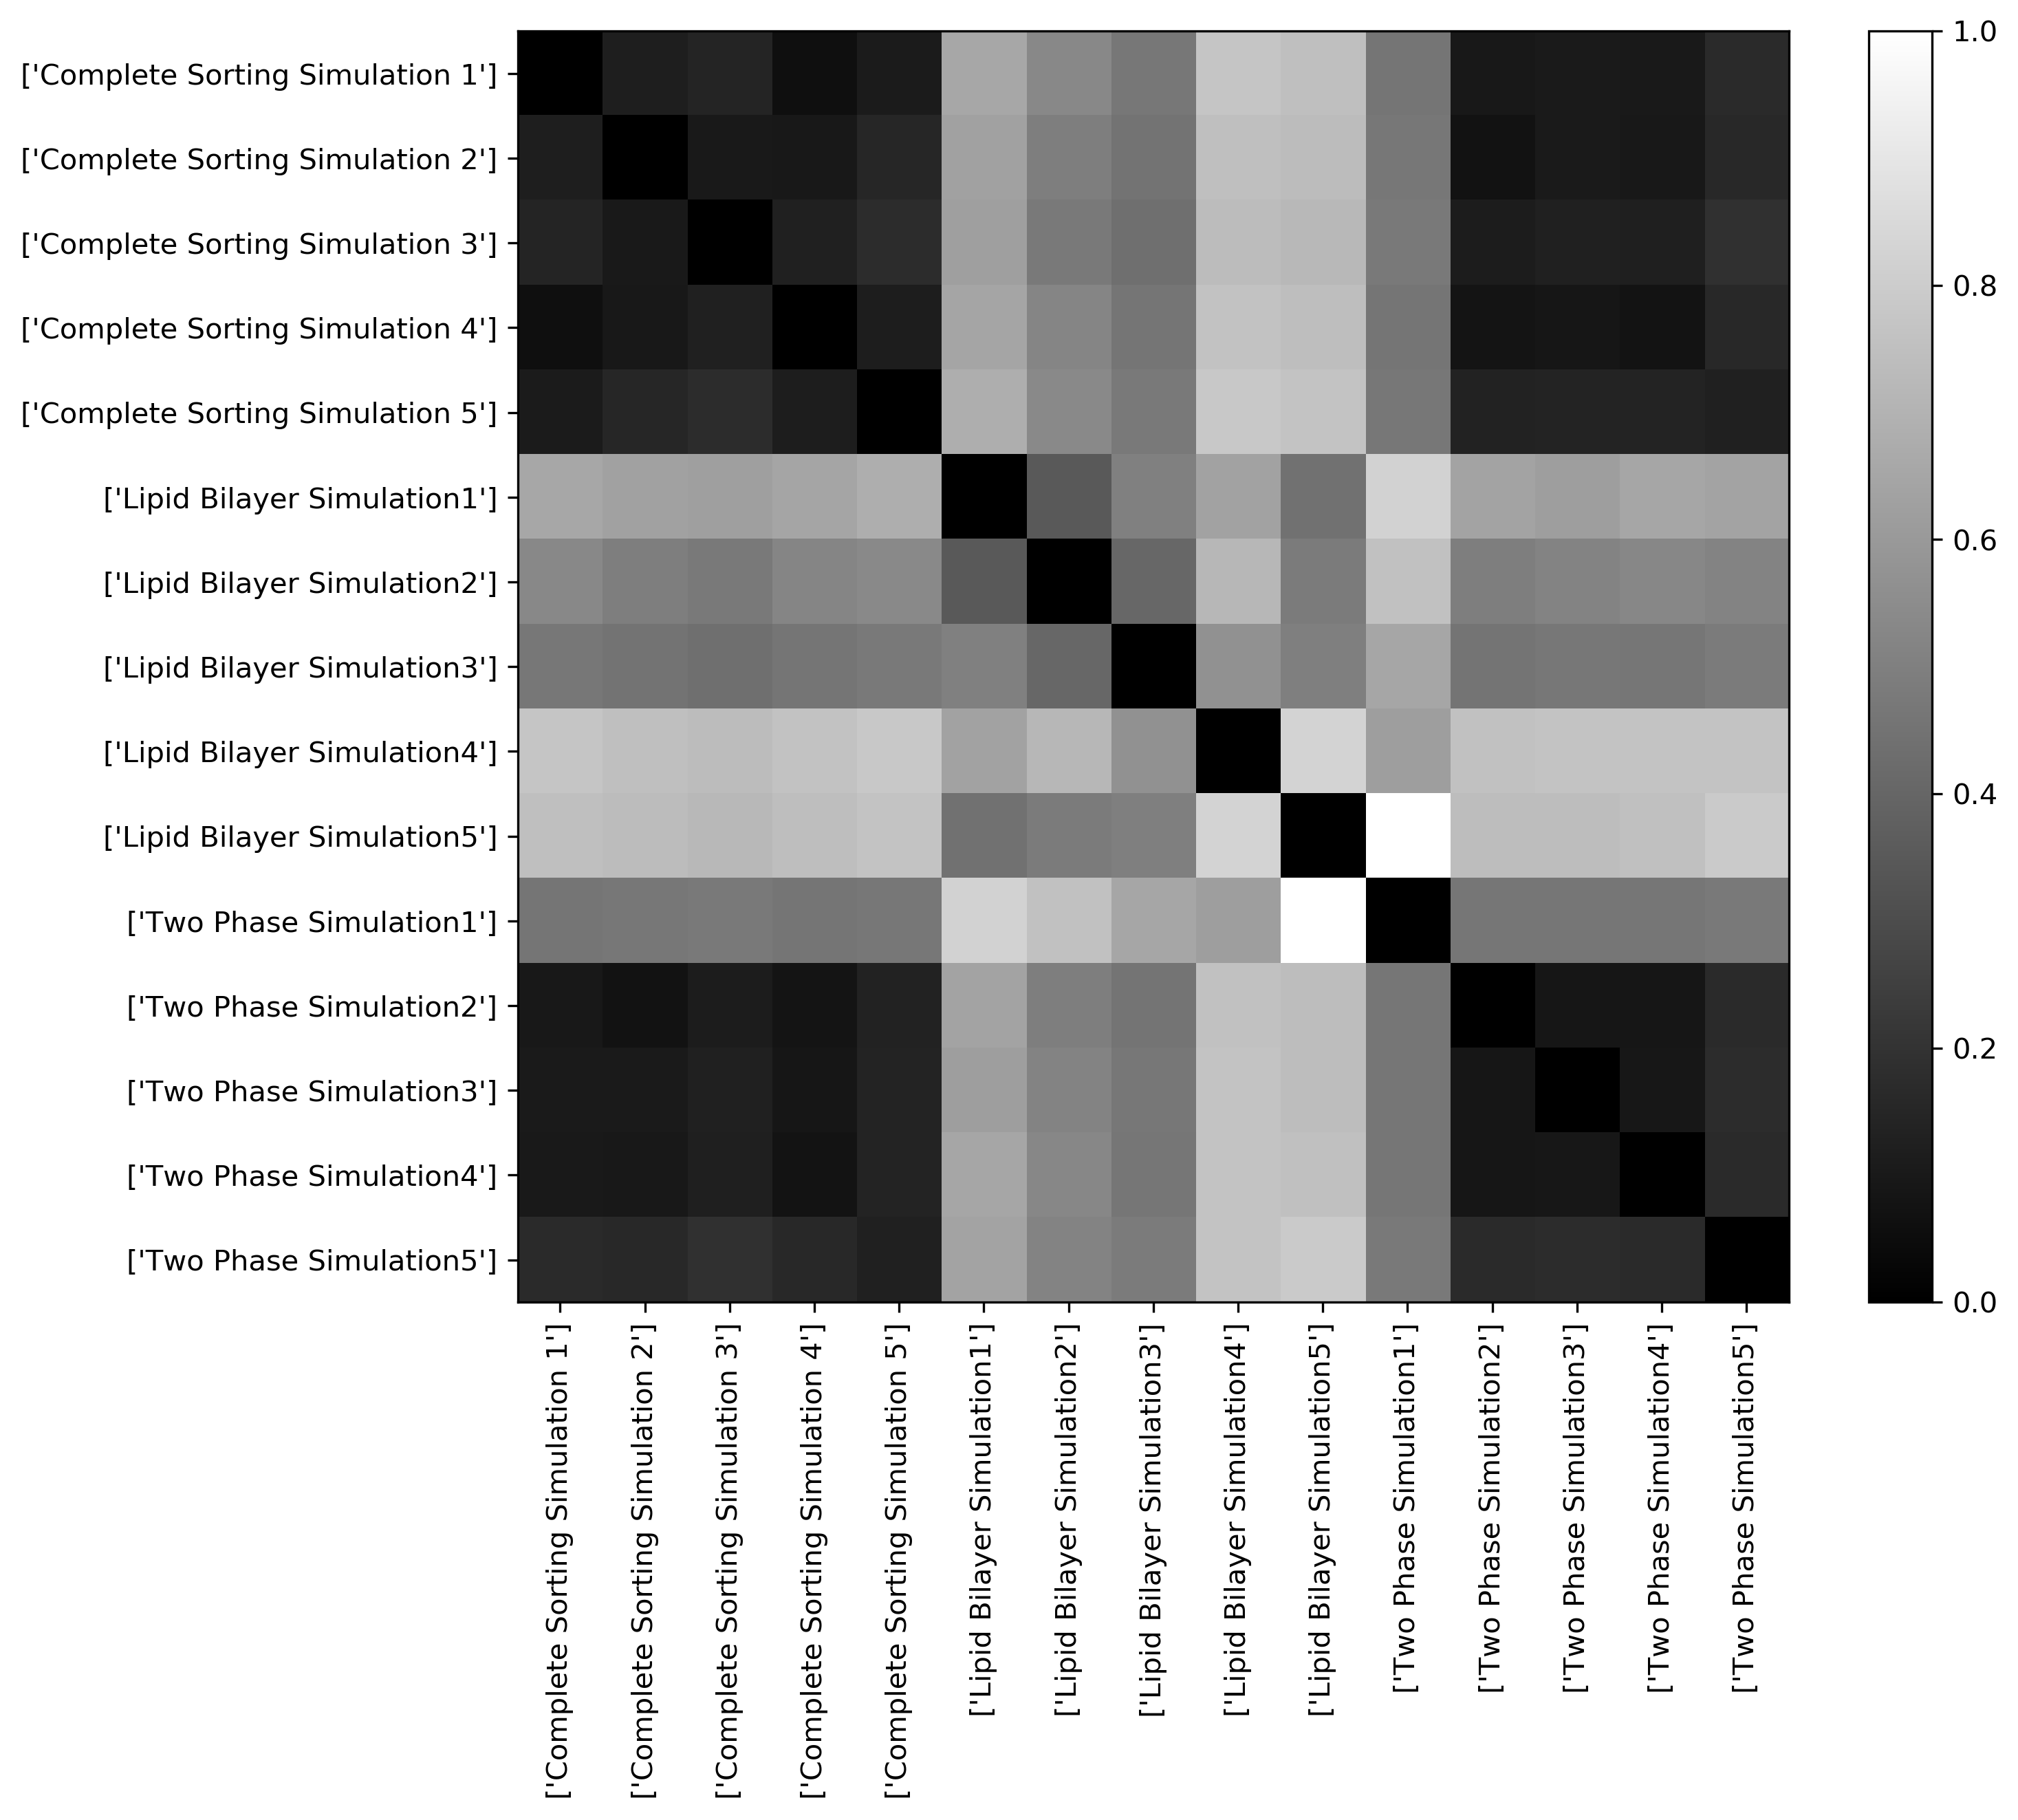

In [270]:
max_coord = maximum(celltype2wasserstein)
wassmatrix = celltype2wasserstein/max_coord

well_names = Array{String}(undef, 15,1);
for i in 1:5
        well_names[i] = string("Complete Sorting Simulation ",i);
        well_names[i+5] = string("Lipid Bilayer Simulation", i);
        well_names[i+10] = string("Two Phase Simulation", i);
end

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:14, well_names, rotation=90);
yticks(0:14, well_names);
colorbar();

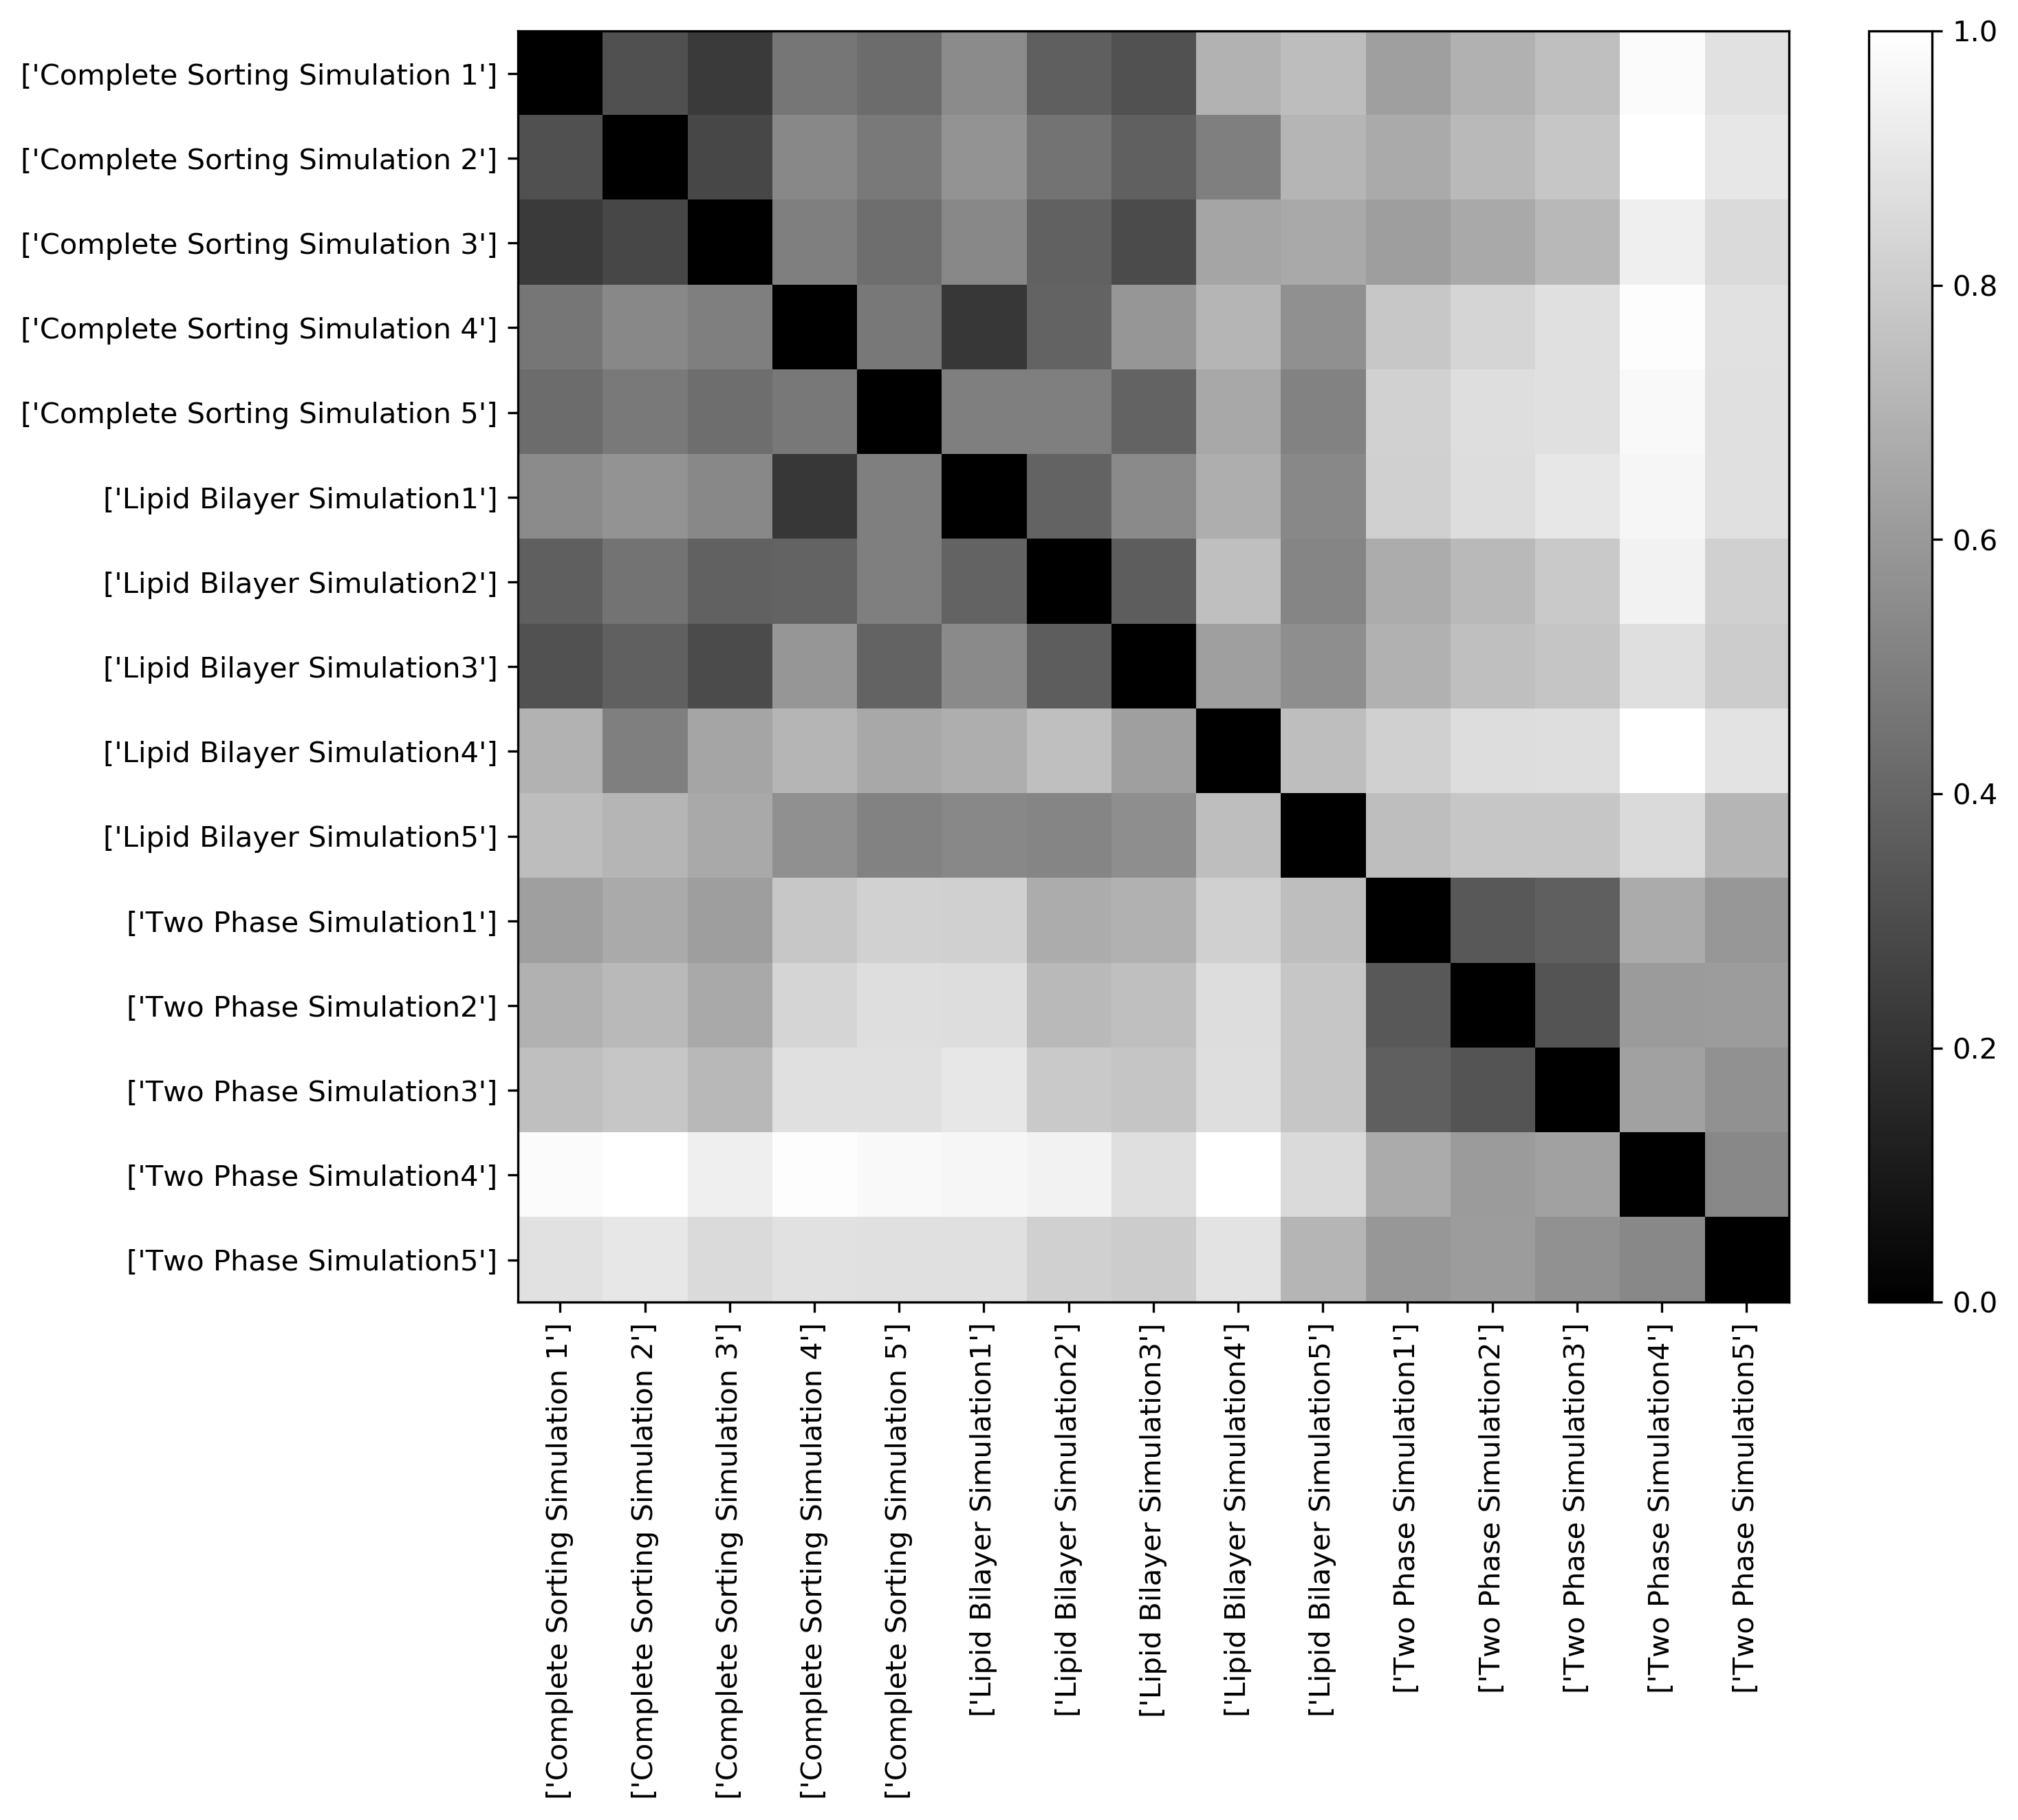

In [272]:
max_coord = maximum(celltogetherwasserstein)
wassmatrix = celltogetherwasserstein/max_coord

well_names = Array{String}(undef, 15,1);
for i in 1:5
        well_names[i] = "Complete Sorting Simulation "*string(i);
        well_names[i+5] = "Lipid Bilayer Simulation"* string(i);
        well_names[i+10] = "Two Phase Simulation"* string(i);
end

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:14, well_names, rotation=90);
yticks(0:14, well_names);
colorbar();

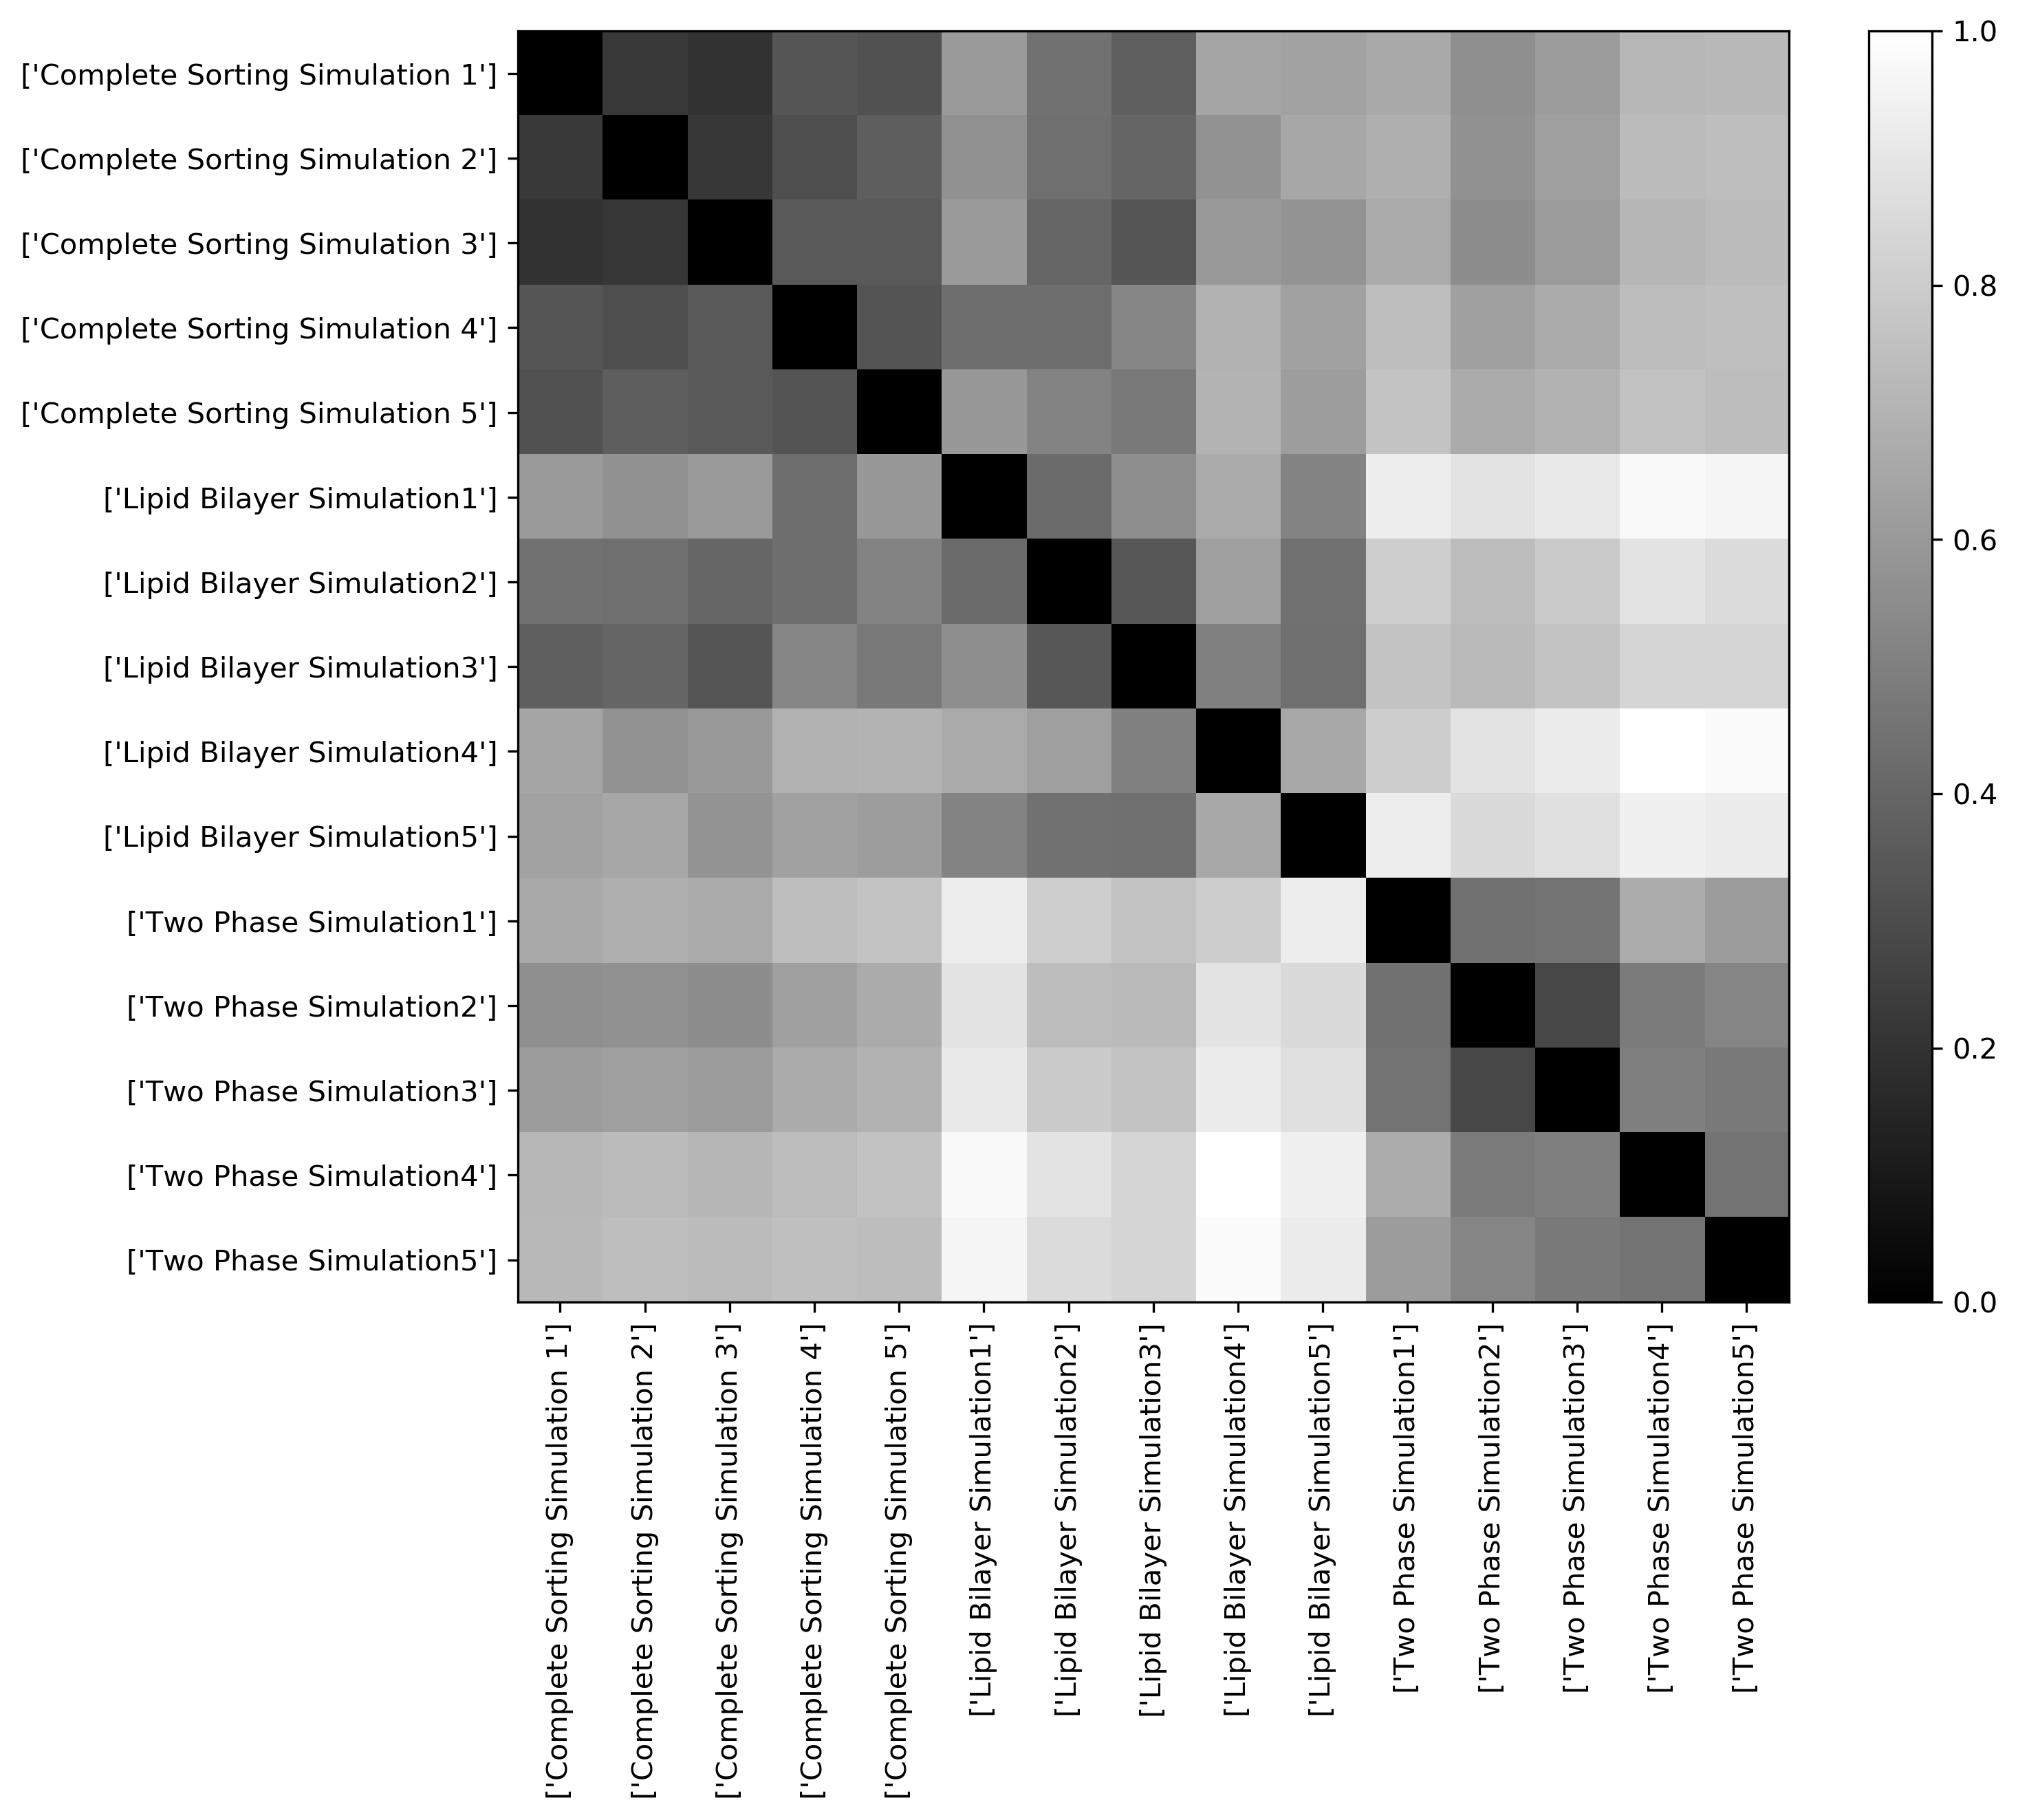

In [273]:
summatrix = celltogetherwasserstein + celltype2wasserstein + celltype1wasserstein;
max_coord = maximum(summatrix)
wassmatrix = summatrix/max_coord

well_names = Array{String}(undef, 15,1);
for i in 1:5
        well_names[i] = "Complete Sorting Simulation "*string(i);
        well_names[i+5] = "Lipid Bilayer Simulation"* string(i);
        well_names[i+10] = "Two Phase Simulation"* string(i);
end

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:14, well_names, rotation=90);
yticks(0:14, well_names);
colorbar();

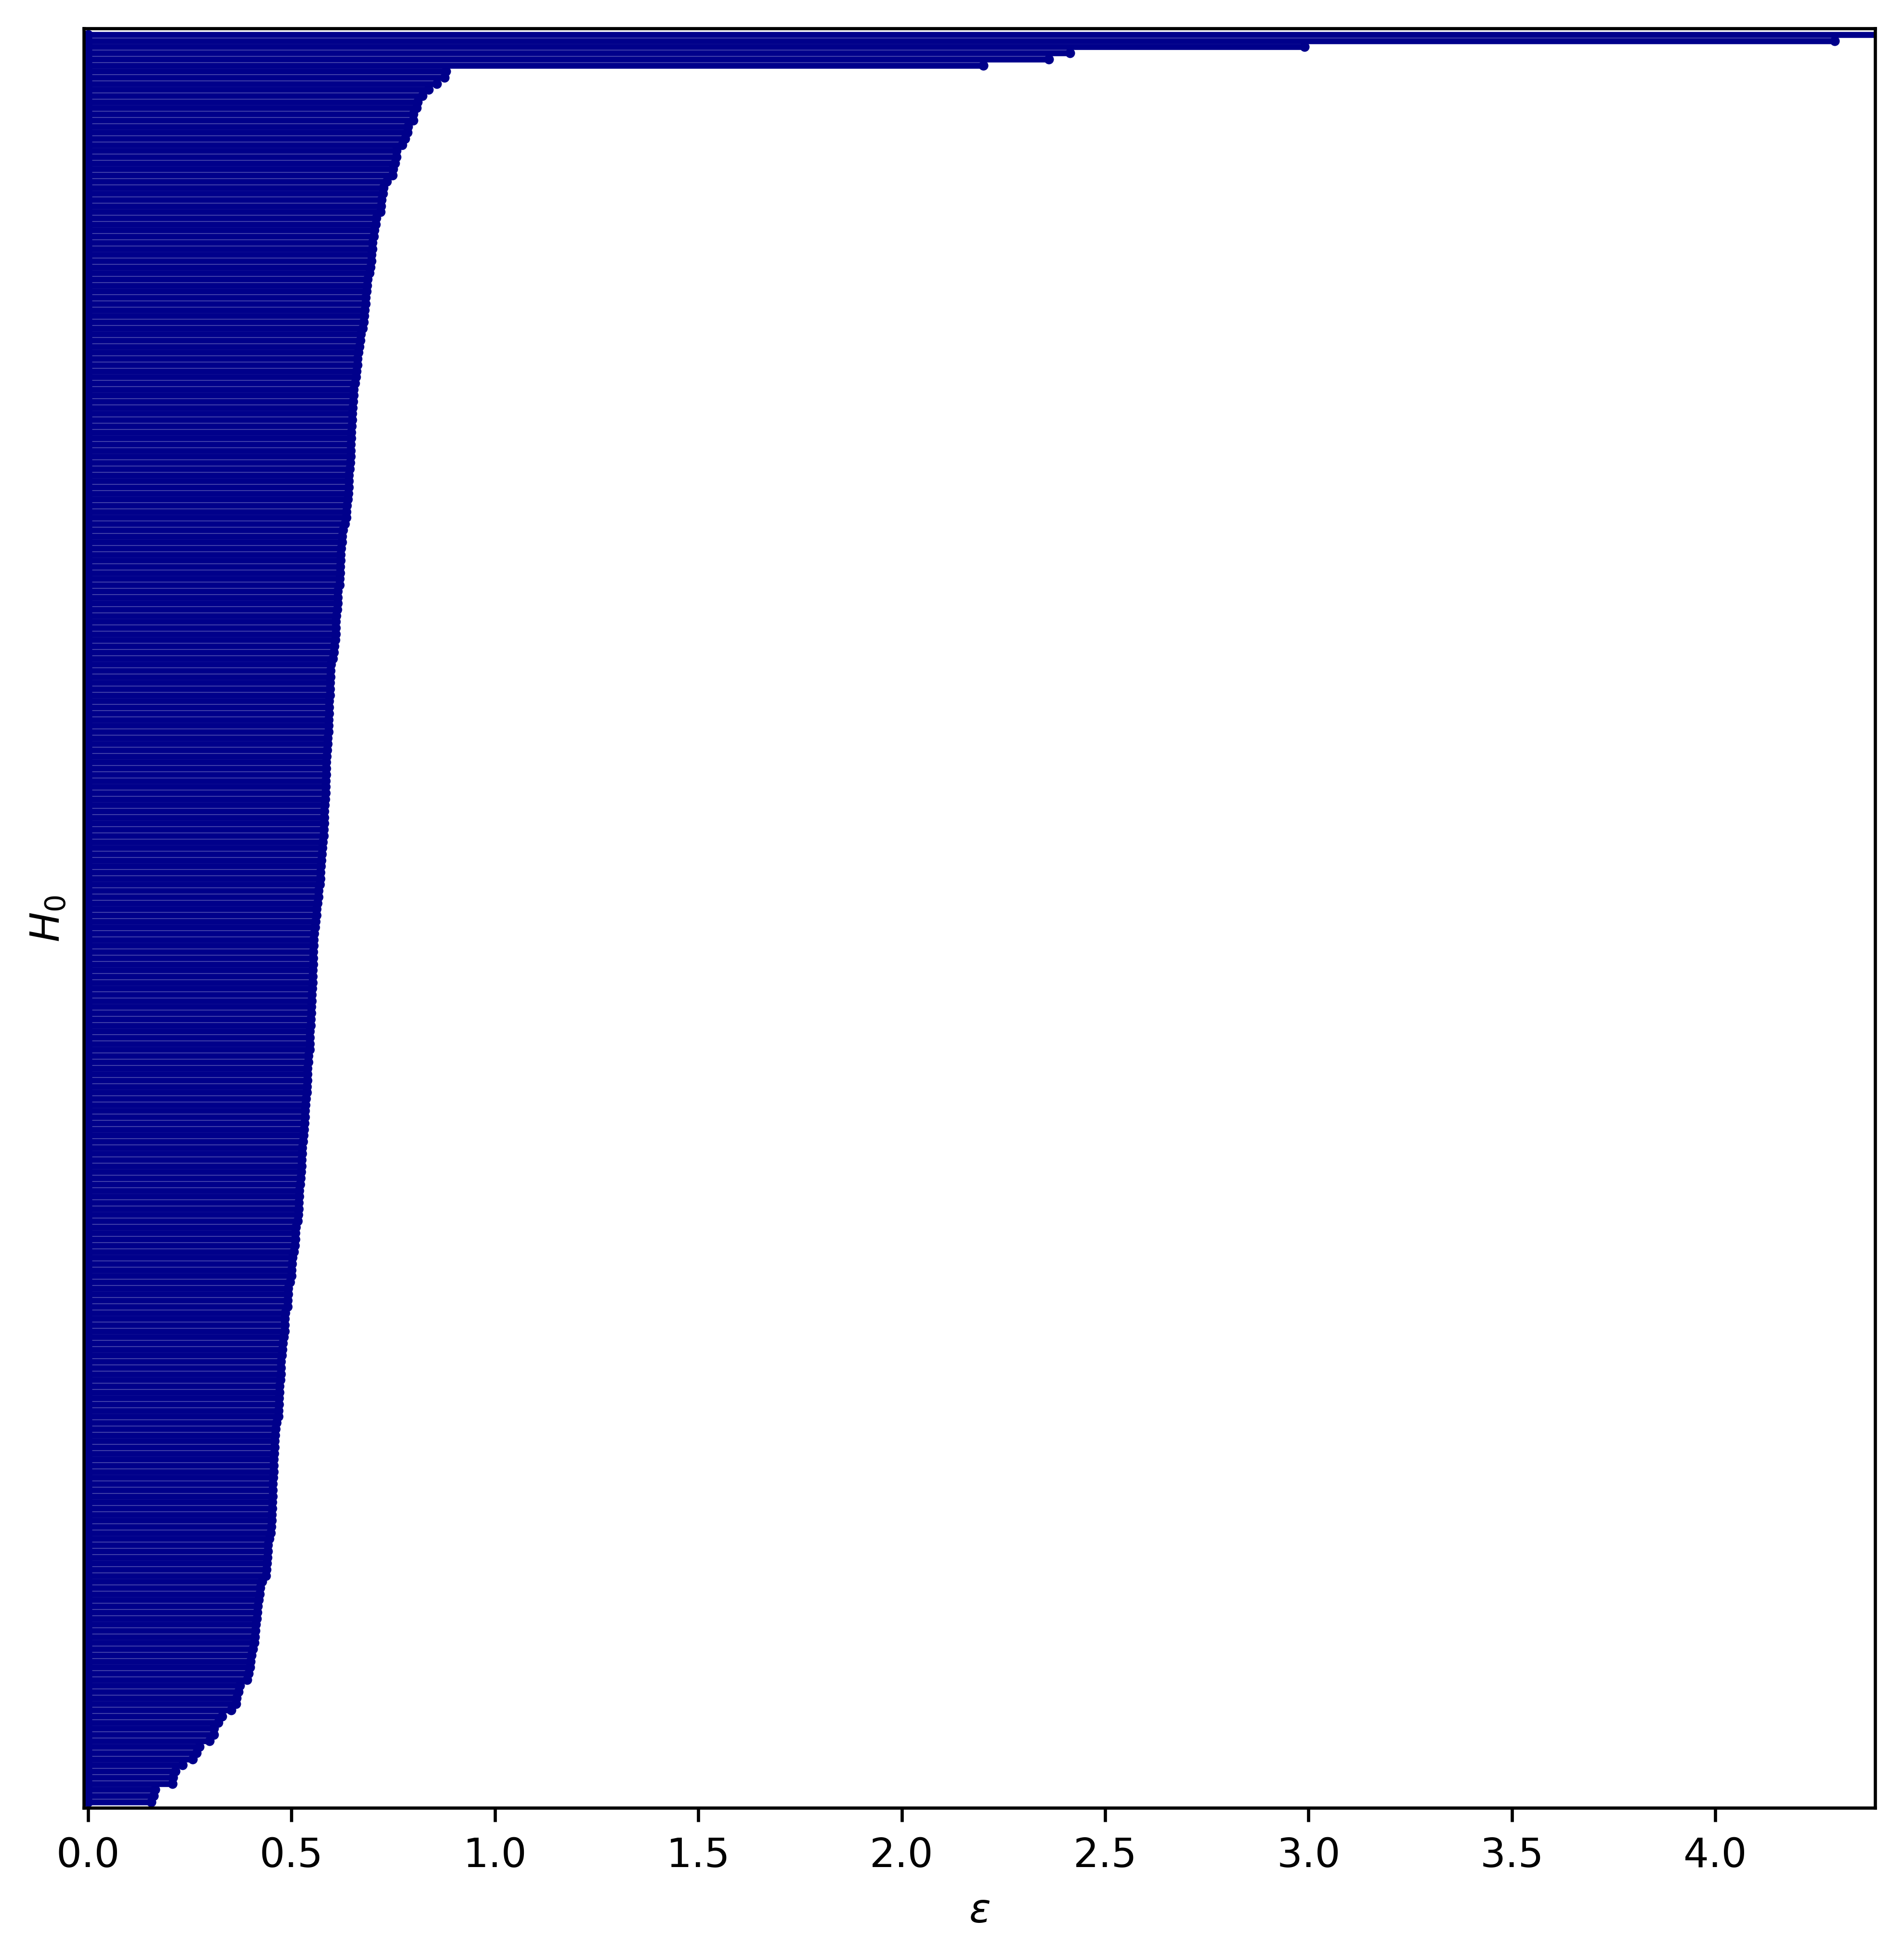

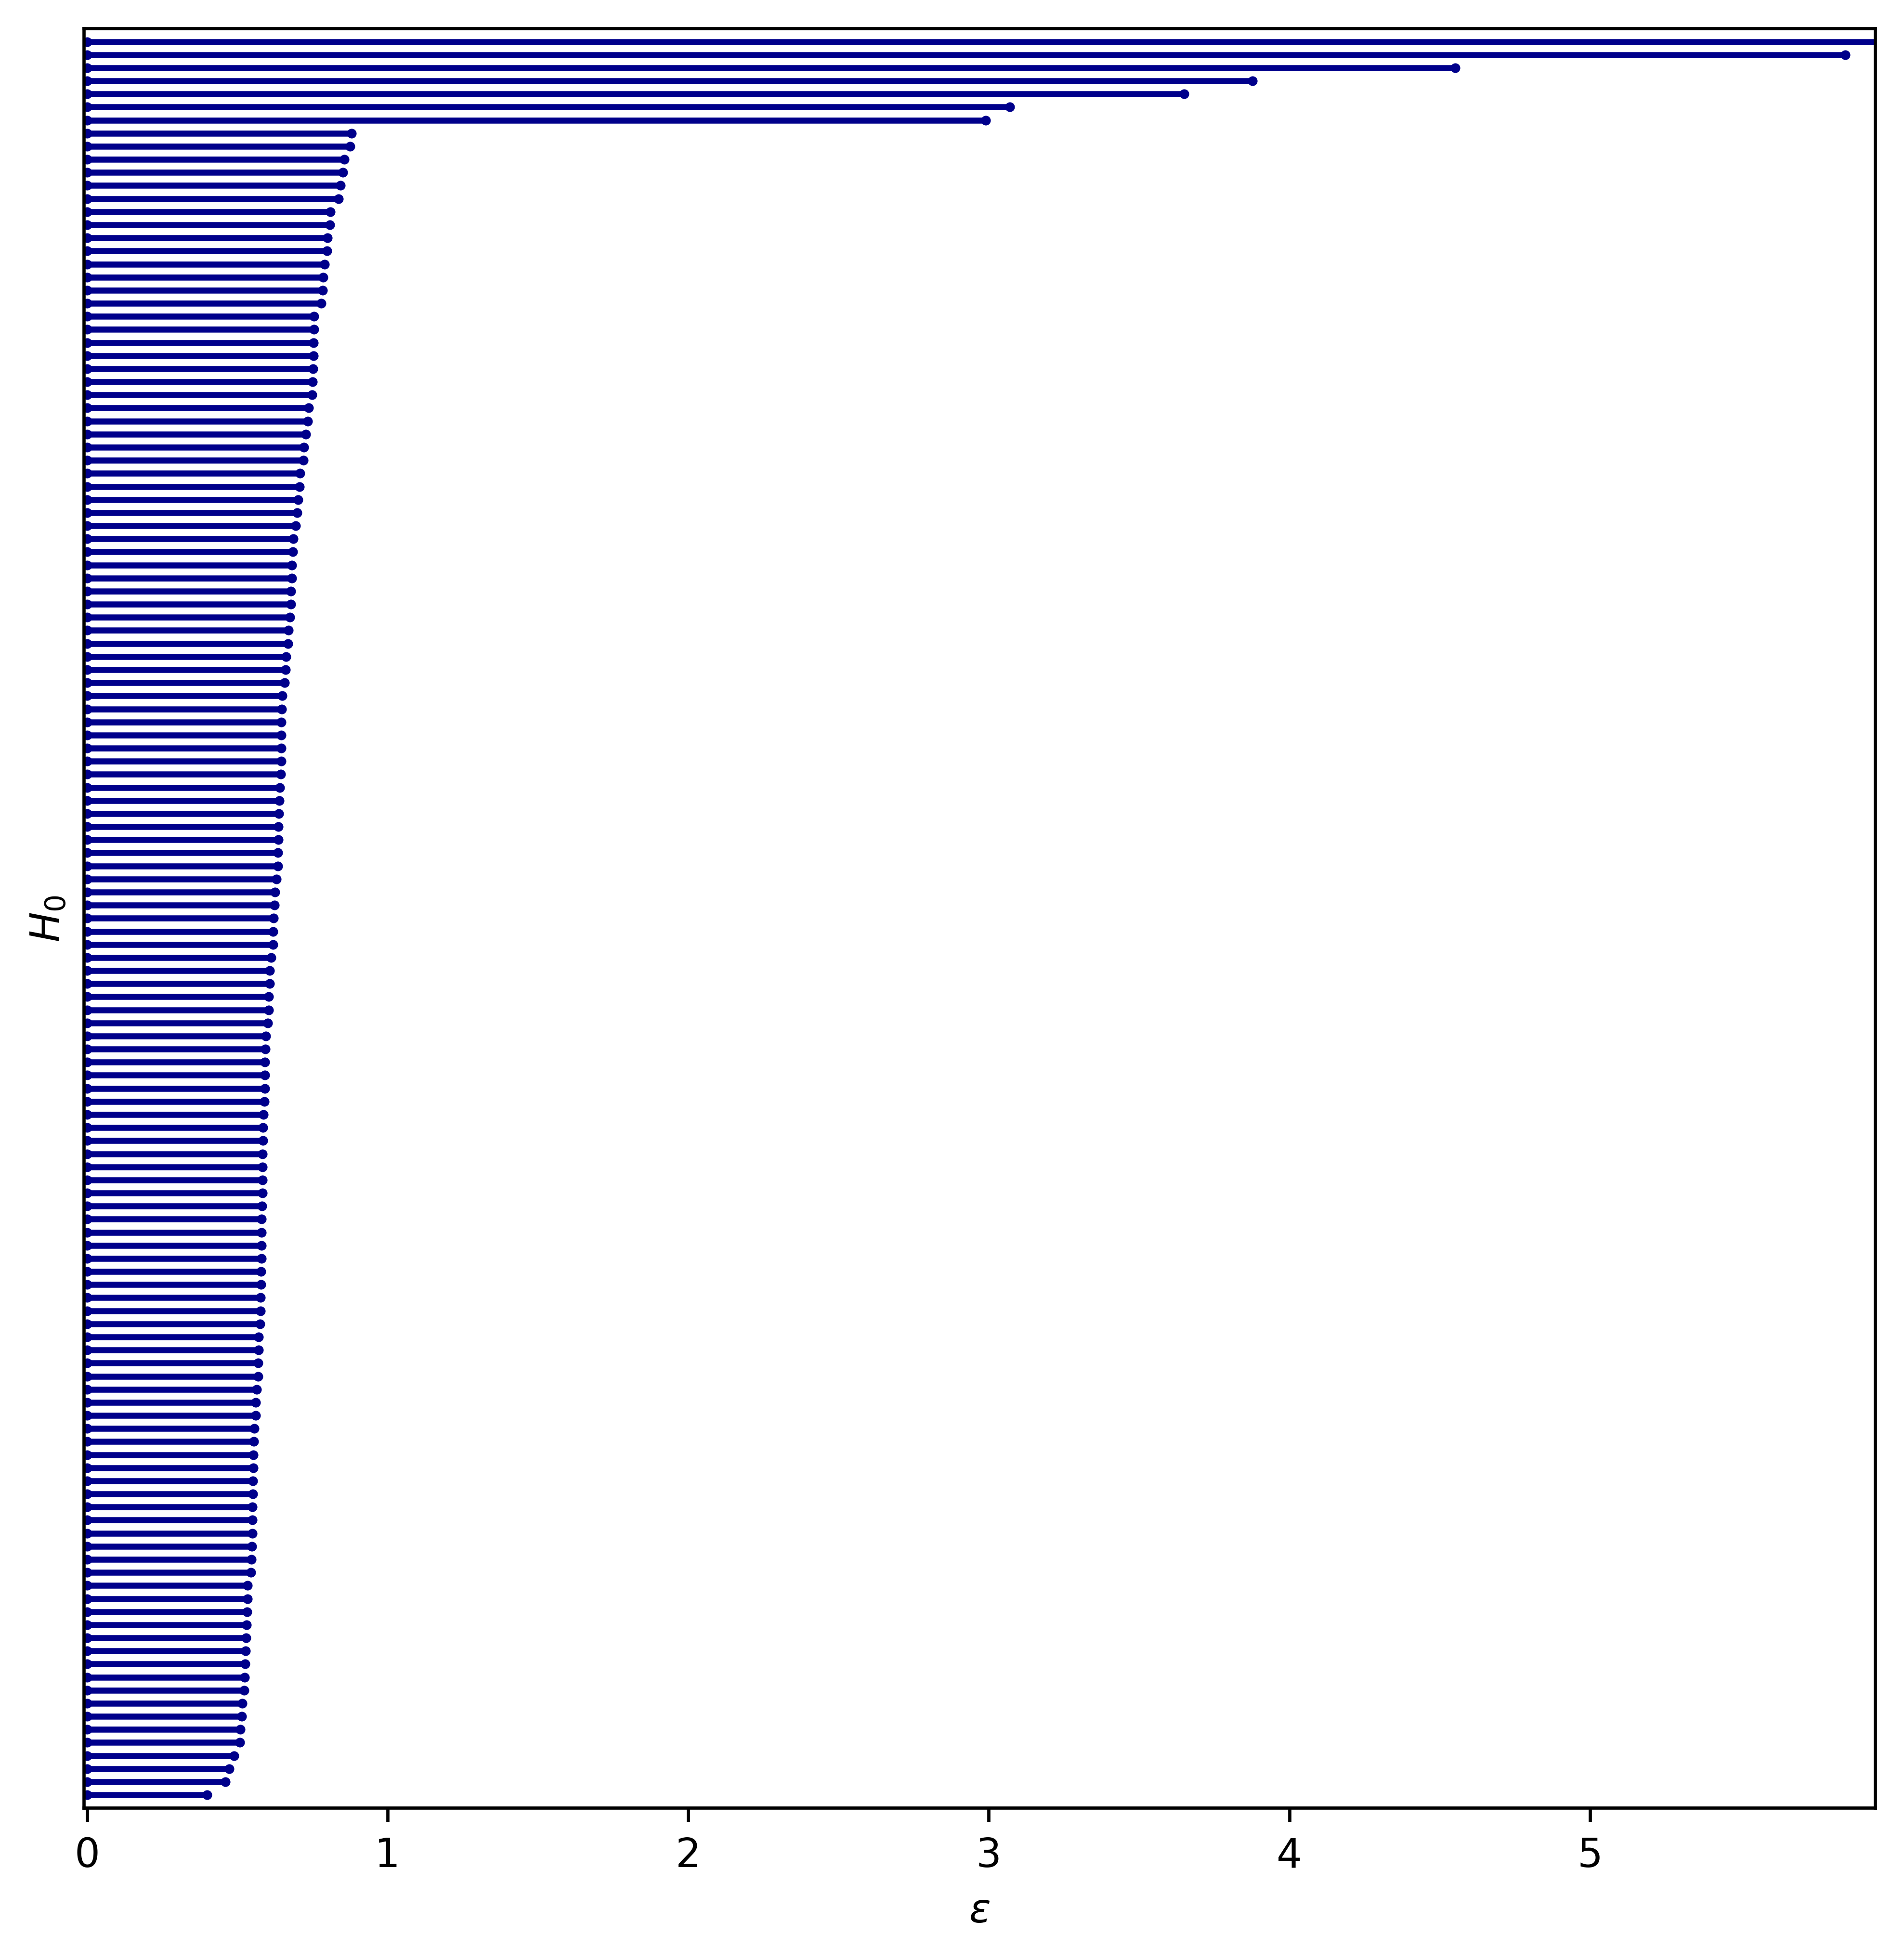